# Gbm Boxplot for PTEN trans effect on MCM2 phosphoproteomics

This notebook creates a boxplot for the trans effect of PTEN cnv deletions for MCM2 in Gbm.

Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import gseapy as gp
import re
import sys 

import cptac
import cptac.utils as u

import sys
import plot_utils as ut

Functions:

format_df prepares a data frame with PTEN proteomics and PTEN mutation types from get_genotype_all_vars.

format_pval_annotation is used to add marks to the boxplot. A star represents significant p-value and "ns" represents a nonsignificant p-value.

In [2]:
# Returns a dataframe with proteomics and mutation type

def format_df(cancer_object, trans_gene, gene_in = 'PTEN', drop_level = 3):
    mut_type = cancer_object.get_genotype_all_vars(gene_in)
    
    if cancer_object.get_cancer_type() not in ('luad'):
        # Keep only tumor samples from proteomics
        prot_and_mutations = cancer_object.join_omics_to_mutations(
            mutations_genes = [gene_in], omics_df_name = 'phosphoproteomics', omics_genes = trans_gene)
        prot_and_mutations = prot_and_mutations[prot_and_mutations.Sample_Status == "Tumor"] # drop Normal samples
        
        # Reduce a multiindex 
        if isinstance(prot_and_mutations.keys(), pd.core.indexes.multi.MultiIndex):
            prot_and_mutations = cancer_object.reduce_multiindex(prot_and_mutations,
                                                                 levels_to_drop=[drop_level], flatten=True)

        # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
        mut_type = mut_type[['Mutation']] 
        prot_df = prot_and_mutations.iloc[:,:-4] # Keep only proteomics
        merged = prot_df.join(mut_type)
        
        # Keep only Wildtype and deletion
        compare = ['Wildtype_Tumor','Deletion']
        get = merged['Mutation'].isin(compare)
        del_wt = merged[get]
    
    
    # Luad has no somatic mutations for PTEN which changes some things
    else: 
        # get_genotype_all_vars add cnv data under the column PTEN
        mut_type = mut_type.drop(columns= gene_in)
        # different code because no somatic mutation data for pten (can't join to somatic mutations)
        omics = cancer_object.join_omics_to_omics(df1_name = 'CNV', df2_name='phosphoproteomics',genes1= gene_in, 
            genes2=trans_gene)
        omics = cancer_object.reduce_multiindex(omics, levels_to_drop = 1, flatten = True)
        omics = omics.drop(columns='PTEN_CNV__')
        # Get only tumor samples
        p = l.get_proteomics(tissue_type='tumor')
        tumor_ids = list(p.index)
        get = omics.index.isin(tumor_ids)
        omics = omics[get]
        # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
        merged = omics.join(mut_type) 
        # Keep only No_Mutation (wildtype) and deletion
        compare = ['No_Mutation','Deletion']
        get = merged['Mutation'].isin(compare)
        del_wt = merged[get]
        del_wt['Mutation'] = np.where(
            del_wt['Mutation'] == 'No_Mutation', 'Wildtype_Tumor', 'Deletion')

    return del_wt


In [3]:
def format_pval_annotation(pval_symbol, x1, x2, line_start = .05, line_height=.05):
    # for manual adjustment to pval annotations
    
    y, h = line_start, line_height
    plt.plot([x1, x1, x2, x2], #draw horizontal line
             [y, y+h, y+h, y], #vertical line
             lw=1.5, color= '.3')
    plt.text((x1+x2)*.5, # half between x coord
             y+h, pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")


# Step 1: Create data frames with PTEN cnv deletion and Proteomics

Each cancer needs a data frame containing only samples that have PTEN cnv deletions or PTEN wildtype tumors and PTEN proteomics.

First, load in cancer data sets from cptac. Note: Keep the variable names the same because they are used in format_df to reduce multiindexs found in certain cancer data sets. 

In [5]:
ls = cptac.Lscc()

cptac warning: The LSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 1)


Next, use format_df to create the specific data frame for each cancer. Use wrap_ttest to test PTEN deletion vs. wildtype. 

# Lscc

In [6]:
gene = 'PTEN'
t_gene = 'MCM2'
ls_del_wt = format_df(ls, t_gene)
ls_del_wt.head()

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 99 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 394)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 201 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 9)


Name,MCM2_phosphoproteomics_S108_AIPELDAYEAEGLALDDEDVEELTAsQR,MCM2_phosphoproteomics_S139_GLLYDsDEEDEERPAR,MCM2_phosphoproteomics_S170_ATEDGEEDEEMIEsIENLEDLK,MCM2_phosphoproteomics_S26S27_RGNDPLTssPGR,MCM2_phosphoproteomics_S27_GNDPLTSsPGR,MCM2_phosphoproteomics_S381_IQEsPGK,MCM2_phosphoproteomics_S40S41_TDALTssPGR,MCM2_phosphoproteomics_S41M77_RTDALTSsPGRDLPPFEDESEGLLGTEGPLEEEEDGEELIGDGmER,MCM2_phosphoproteomics_T158_QVERAtEDGEEDEEMIESIENLEDLK,MCM2_phosphoproteomics_T25_RRGNDPLtSSPGR,Mutation
Patient_ID,,,,,,,,,,,
C3L-00081,NaN,1.0437,NaN,-0.0374,0.5615,NaN,0.3830,0.3563,NaN,1.9446,Deletion
C3L-00415,1.4818,0.7056,1.1065,NaN,NaN,-1.2280,0.9578,0.7101,-0.3497,0.3243,Wildtype_Tumor
C3L-00445,0.0843,0.5319,-0.0160,0.5257,1.3807,1.1300,0.6222,1.7907,NaN,0.3802,Deletion
C3L-00568,-0.1885,0.6663,0.4402,NaN,NaN,1.1167,-0.1636,1.4081,1.3506,0.8407,Wildtype_Tumor
C3L-00603,0.0742,1.4027,2.1734,2.3722,1.4256,1.1982,1.1453,0.7978,NaN,0.8536,Wildtype_Tumor


In [7]:
cols = list(ls_del_wt.columns[:-1])

ls_pval = u.wrap_ttest(ls_del_wt, 'Mutation', cols)#, return_all = True)
lsp = ls_pval['P_Value']
ls_pval

,Comparison,P_Value
0,MCM2_phosphoproteomics_T25_RRGNDPLtSSPGR,0.000268
1,MCM2_phosphoproteomics_S41M77_RTDALTSsPGRDLPPF...,0.000956
2,MCM2_phosphoproteomics_S139_GLLYDsDEEDEERPAR,0.001413


In [23]:
ls_sig = list(ls_pval.Comparison)
ls_df = ls_del_wt.columns.isin(ls_sig)
ls_sig_df = ls_del_wt[ls_del_wt.columns[ls_df]]

ls_sig_df = ls_sig_df.rename(columns=lambda x: re.sub('_phosphoproteomics','', x))
ls_sig_df = ls_sig_df.rename(columns=lambda x: re.sub('_[st]?[A-Z]+[st]+[A-Z]*[st]*[A-Z]*$', '', x))

s139 = ls_sig_df[['MCM2_S139']]

ls_mut = ls_del_wt[['Mutation']]
sig_site_df = s139.join(ls_mut)
sig_site_df['Site'] = 'MCM2_S139'
sig_site_df

Name,MCM2_S139,Mutation,Site
Patient_ID,,,
C3L-00081,1.0437,Deletion,MCM2_S139
C3L-00415,0.7056,Wildtype_Tumor,MCM2_S139
C3L-00445,0.5319,Deletion,MCM2_S139
C3L-00568,0.6663,Wildtype_Tumor,MCM2_S139
C3L-00603,1.4027,Wildtype_Tumor,MCM2_S139
...,...,...,...
C3N-03886,2.6035,Deletion,MCM2_S139
C3N-04124,-0.4429,Wildtype_Tumor,MCM2_S139
C3N-04127,-0.6074,Wildtype_Tumor,MCM2_S139


# Create the Boxplot

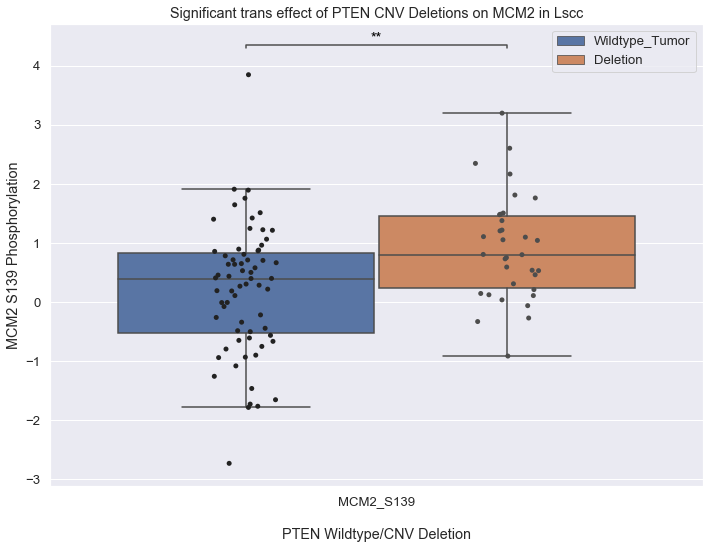

In [31]:
gene = 'PTEN'
plt.rcParams['figure.figsize']=(11.7,8.5) #size of plot
sns.set(font_scale = 1.2)

boxplot = sns.boxplot(x='Site', y='MCM2_S139', data = sig_site_df,hue = 'Mutation',
                      hue_order = ["Wildtype_Tumor", "Deletion"],
                      showfliers = False)    
boxplot.set_title('Significant trans effect of PTEN CNV Deletions on '+t_gene+' in Lscc')
boxplot = sns.stripplot(x='Site', y='MCM2_S139', data = sig_site_df, jitter = True, 
                           color = ".3",dodge = True, hue = 'Mutation',
                        hue_order = ["Wildtype_Tumor", "Deletion"])
boxplot.set(xlabel = "\n"+gene+" Wildtype/CNV Deletion", ylabel = t_gene+' S139 Phosphorylation')

#boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=45)


# format legend
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2])


# Create significance symbols:
# * P ≤ 0.05   ** P ≤ 0.01   *** P ≤ 0.001 

format_pval_annotation("**", -.2, .2, 4.3) 



plt.show()
plt.clf()
plt.close()

In [143]:
ls_pval

,Comparison,P_Value
0,MCM2_phosphoproteomics_T25_RRGNDPLtSSPGR,0.000268
1,MCM2_phosphoproteomics_S41M77_RTDALTSsPGRDLPPF...,0.000956
2,MCM2_phosphoproteomics_S139_GLLYDsDEEDEERPAR,0.001413


In [144]:
g_pval

,Comparison,P_Value
0,MCM2_phosphoproteomics_S139_GLLYDS*DEEDEERPARK,0.000192
1,MCM2_phosphoproteomics_S139_RGLLYDS*DEEDEERPAR,0.001449


In [ ]:
# Save figure
#fig = boxplot.get_figure()
#fig.savefig(".png")